Imports

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime
from collections import Counter
import json

Carregando dataset

In [8]:
file_names = [
    'scraped_tweets_09_16_22.json',
    'scraped_tweets_09_23_22.json',
    'scraped_tweets_09_30_22.json',
    'scraped_tweets_10_07_22.json',
    'scraped_tweets_10_14_22.json',
    'scraped_tweets_10_21_22.json',
    'scraped_tweets_10_28_22.json',
    'scraped_tweets_11_04_22.json',
    'scraped_tweets_11_11_22.json'
]

df = pd.DataFrame() # dataframe vazio

for file_name in file_names: #inserir dados no dataframe
    file_path = f'{file_name}'
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            df = pd.concat([df, pd.json_normalize(data)], ignore_index=True)
    except Exception as e:
        print(f"Erro ao ler o arquivo {file_path}: {str(e)}")

Conversões

In [9]:
df['created_at'] = pd.to_datetime(df['created_at'], utc=True) # Converter a coluna 'created_at' para o tipo datetime

df['date'] = df['created_at'].dt.date # Criar uma nova coluna 'date' para agrupar os tweets por data

# Análise de Tendências ao Longo do Tempo

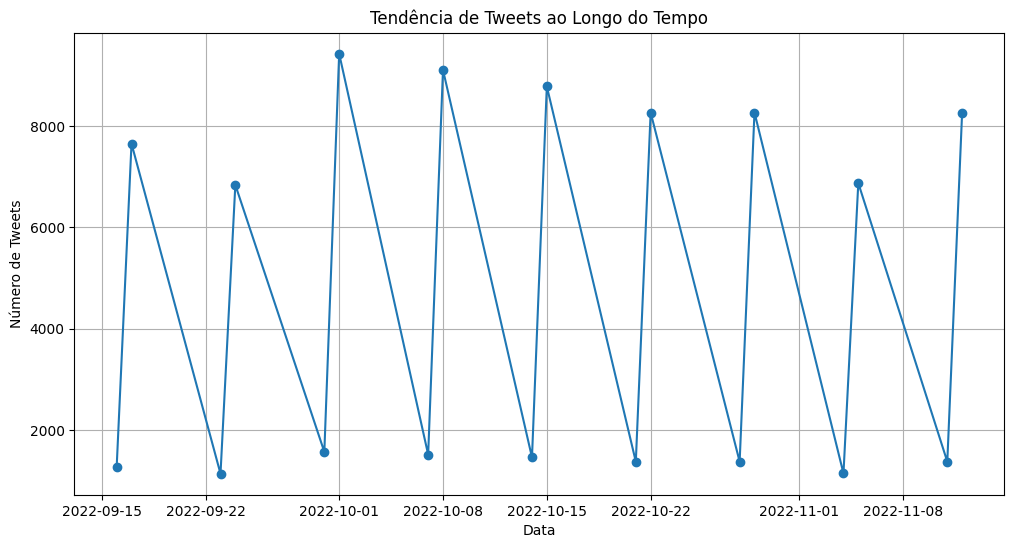

In [10]:
daily_tweet_count = df['date'].value_counts().sort_index() #tweets ao longo do tempo

plt.figure(figsize=(12, 6))
plt.plot(daily_tweet_count, marker='o')
plt.title('Tendência de Tweets ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Número de Tweets')
plt.grid(True)
plt.show()

# Identificação de Hashtags Populares

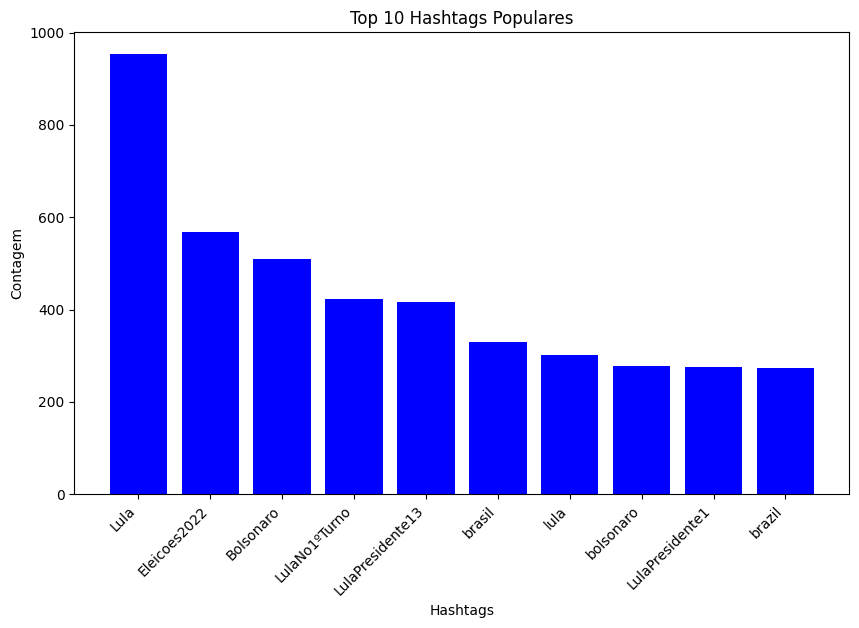

In [13]:
all_hashtags = [tag['text'] for sublist in df['hashtags'] for tag in sublist] # lista com todas as hashtags

counter = Counter(all_hashtags) # ocorrencia de cada hashtag

top_hashtags = counter.most_common(10) # 10 hashtags mais comuns

hashtags, counts = zip(*top_hashtags) # Separa as hashtags e as contagens para plotagem

plt.figure(figsize=(10, 6))
plt.bar(hashtags, counts, color='blue')
plt.xlabel('Hashtags')
plt.ylabel('Contagem')
plt.title('Top 10 Hashtags Populares')
plt.xticks(rotation=45, ha='right')
plt.show()


# Análise de Comunidades de Hashtags usando NetworkX

C:\Users\andso\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26152 (\N{CJK UNIFIED IDEOGRAPH-6628}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\andso\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\andso\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\andso\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\andso\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12481 (\N{KATAKANA L

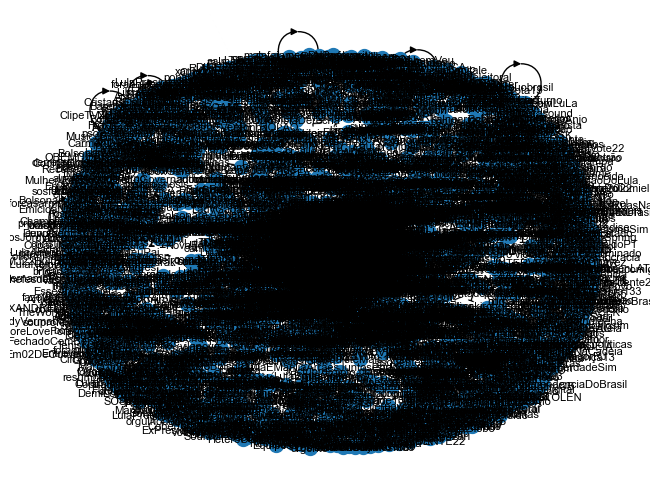

In [14]:
# Criar um grafo direcionado ponderado
G = nx.DiGraph()

# Adicionar arestas ponderadas com base nas hashtags
for hashtags_list in df['hashtags']:
    for i in range(len(hashtags_list)):
        for j in range(i + 1, len(hashtags_list)):
            hashtag1 = hashtags_list[i]['text']
            hashtag2 = hashtags_list[j]['text']
            
            if G.has_edge(hashtag1, hashtag2):
                G[hashtag1][hashtag2]['weight'] += 1
            else:
                G.add_edge(hashtag1, hashtag2, weight=1)

# Visualização do grafo
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_size=8, node_size=100, font_color='black', font_family='arial')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

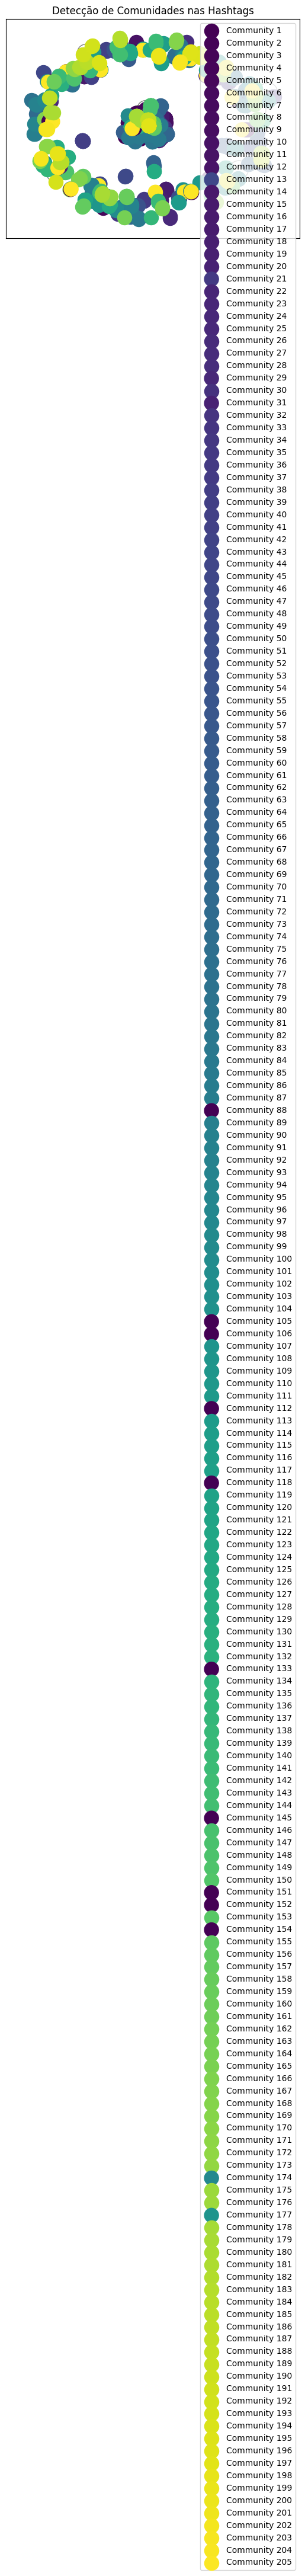

In [24]:
import community 
# Criar um grafo ponderado
G = nx.Graph()

# Adicionar arestas ponderadas com base nas hashtags
for hashtags_list in df['hashtags']:
    for i in range(len(hashtags_list)):
        for j in range(i + 1, len(hashtags_list)):
            hashtag1 = hashtags_list[i]['text']
            hashtag2 = hashtags_list[j]['text']
            
            if G.has_edge(hashtag1, hashtag2):
                G[hashtag1][hashtag2]['weight'] += 1
            else:
                G.add_edge(hashtag1, hashtag2, weight=1)

# Detecção de comunidades usando o algoritmo Louvain Modularity
partition = community.best_partition(G)

# Adicionar a informação de comunidade aos nós do grafo
for node, community_id in partition.items():
    G.nodes[node]['community'] = community_id

# Visualização das comunidades
pos = nx.spring_layout(G)
communities = set(partition.values())
colors = [plt.cm.viridis(i / len(communities)) for i in communities]

for i, community_id in enumerate(communities):
    nodes_in_community = [node for node, comm_id in partition.items() if comm_id == community_id]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_community, node_color=colors[i], label=f'Community {i+1}')

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Detecção de Comunidades nas Hashtags')
plt.legend()
plt.show()

In [25]:
# Criar um dicionário para armazenar as hashtags de cada comunidade
communities_hashtags = {community_id: [] for community_id in set(partition.values())}

# Preencher o dicionário com as hashtags de cada comunidade
for node, community_id in partition.items():
    hashtag = node
    communities_hashtags[community_id].append(hashtag)

# Gravar as hashtags em um arquivo de texto (usando UTF-8)
with open('hashtags_por_comunidade.txt', 'w', encoding='utf-8') as file:
    for community_id, hashtags in communities_hashtags.items():
        file.write(f'Comunidade {community_id}:\n')
        file.write(', '.join(hashtags))
        file.write('\n\n')

print("Hashtags por comunidade foram gravadas no arquivo 'hashtags_por_comunidade.txt'")

Hashtags por comunidade foram gravadas no arquivo 'hashtags_por_comunidade.txt'


In [30]:
# Filtrar as comunidades com base nas hashtags desejadas e com mais de 4 hashtags
filtered_communities = [comm_id for comm_id in set(partition.values()) if len(communities_hashtags[comm_id]) > 4 and any(any(keyword in hashtag.lower() for keyword in ["bolsonaro", "lula", "eleicoes", "brazil", "brasil", "elections"]) for hashtag in communities_hashtags[comm_id])]

# Criar um subgrafo com as comunidades filtradas
filtered_communities_graph = G.subgraph([node for node, comm_id in partition.items() if comm_id in filtered_communities])

i = 0

# Salvar as comunidades filtradas em um arquivo txt
with open('top_ten_filtered_communities.txt', 'w', encoding='utf-8') as file:
    for comm_id in filtered_communities:
        if(i < 10): 
            hashtags_in_community = [hashtag for hashtag in communities_hashtags[comm_id] if any(keyword in hashtag.lower() for keyword in ["bolsonaro", "lula", "eleicoes", "brazil", "brasil", "elections"])]
            file.write(f'Comunidade {comm_id}:\n')
            file.write(', '.join(hashtags_in_community))
            file.write('\n\n')
            i = i + 1

print("Comunidades filtradas foram gravadas no arquivo 'top_ten_filtered_communities.txt'")



Comunidades filtradas foram gravadas no arquivo 'filtered_communities.txt'
